In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [24]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

cuda


In [25]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTGAN/dataset/train_category.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTGAN/dataset/test_category.csv"
test_data = pd.read_csv(test_data_path)

In [26]:
#keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']
keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']

data_classification = data.copy()
test_classification = test_data.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)

In [27]:
## data Encoding
Labelencoding_features = ['term_months', 'sub_grade']
onehot_features = ['debt_settlement_flag', 'home_ownership', 'purpose']

onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

label_encoders = {}
for col in Labelencoding_features:
    le = LabelEncoder()
    data_classification[col] = le.fit_transform(data_classification[col])
    label_encoders[col] = le

# One-Hot Encoding
onehot_encoded = onehot_encoder.fit_transform(data_classification[onehot_features])
onehot_encoded_df = pd.DataFrame(
    onehot_encoded, 
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=data_classification.index
)

# Merge
data_classification.drop(columns=onehot_features, inplace=True)
data_classification = pd.concat([data_classification, onehot_encoded_df], axis=1)

print("✅ Encoding 완료! 결과 shape:", data_classification.shape)

✅ Encoding 완료! 결과 shape: (1116458, 35)


In [28]:
test_data['grade'].value_counts()

grade
B    218051
C    211471
A    138624
D    110235
E     46638
F     14978
G      4309
Name: count, dtype: int64

In [29]:
##Test data encoding
for col in Labelencoding_features:
    le = label_encoders[col]
    test_classification[col] = le.transform(test_classification[col])

# One-Hot Encoding (train에서 fit된 onehot_encoder 재사용)
onehot_encoded_test = onehot_encoder.transform(test_classification[onehot_features])
onehot_encoded_test_df = pd.DataFrame(
    onehot_encoded_test,
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=test_classification.index
)

# Merge
test_classification.drop(columns=onehot_features, inplace=True)
test_classification = pd.concat([test_classification, onehot_encoded_test_df], axis=1)

print("✅ 테스트 데이터 인코딩 완료! 결과 shape:", test_classification.shape)

✅ 테스트 데이터 인코딩 완료! 결과 shape: (744306, 35)


In [30]:
def encode_features(df, label_encoders, onehot_encoder, label_cols, onehot_cols):
    df = df.copy()
    
    # Label Encoding
    for col in label_cols:
        le = label_encoders[col]
        df[col] = le.transform(df[col])

    # One-Hot Encoding
    onehot_encoded = onehot_encoder.transform(df[onehot_cols])
    onehot_df = pd.DataFrame(
        onehot_encoded, 
        columns=onehot_encoder.get_feature_names_out(onehot_cols),
        index=df.index
    )

    df.drop(columns=onehot_cols, inplace=True)
    df = pd.concat([df, onehot_df], axis=1)
    
    return df

In [31]:
##상위 10% 투자
from imblearn.over_sampling import SMOTE
drop2 = ['loan_status', 'return']

def select_fully_paid(y_pred, method):
    scaler = StandardScaler()
    reg = LinearRegression()

    fully_paid_indices = (y_pred == 0)
    test_regression = test_data[fully_paid_indices]
    test_regression['return'] = (test_regression['total_pymnt_inv'] - test_regression['funded_amnt'])/test_regression['funded_amnt']

    train_regression = data.copy()

    if method == 'Base':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']

        drop_features = ['loan_status','grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)

        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        data_x = train_regression.drop(columns='return')
        data_y = train_regression[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)

        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))
        return method, top_10_percent
    
    elif method == 'Undersampling':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['loan_amnt'])/train_regression['funded_amnt']
        drop_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)

        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        X_train = train_regression.drop(columns='loan_status')
        y_train = train_regression[['loan_status']]

        undersampler = RandomUnderSampler(random_state=42)
        X_under, y_under = undersampler.fit_resample(X_train, y_train)

        data_under = pd.concat([pd.DataFrame(X_under, columns=X_train.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)

        data_x = data_under.drop(columns=drop2)  
        data_y = data_under[['return']]  

        test_x = test_regression.drop(columns = drop2)
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)

        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))

        return method, top_10_percent
    
    elif method == 'SMOTE-NC':
        smote_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/smotenc/smotenc_data.csv"
        data_smote = pd.read_csv(smote_path)
        
        data_smote['return'] = (data_smote['total_pymnt_inv'] - data_smote['funded_amnt'])/data_smote['funded_amnt']
        drop_features = ['loan_status','grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']

        train_regression = data_smote.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)

        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        X_train = train_regression.drop(columns='return')
        y_train = train_regression[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(X_train)

        X_train = data_x_scaled
        #y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))

        return method, top_10_percent
    
    elif method == 'table-gan':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']
        drop_features = ['loan_status','grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)
        
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/tablegan/tablegan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        fake_regression = fake.copy()

        fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
        fake_regression = fake_regression.drop(columns=drop_features)
        fake_regression['term_months'] = fake_regression['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)

        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        fake_regression = encode_features(fake_regression,label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        train_total = pd.concat([train_regression, fake_regression])

        data_x = train_total.drop(columns='return')
        data_y = train_total[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))

        return method, top_10_percent
        
    elif method == 'Smotified-tablegan':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']
        drop_features = ['loan_status','grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)
        
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/tablegan/smotified-tablegan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        fake_regression = fake.copy()

        fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
        fake_regression = fake_regression.drop(columns=drop_features)
        fake_regression['term_months'] = fake_regression['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)

        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        fake_regression = encode_features(fake_regression,label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        train_total = pd.concat([train_regression, fake_regression])

        data_x = train_total.drop(columns='return')
        data_y = train_total[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))

        return method, top_10_percent 
    
    elif method == 'vae-tablegan':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']
        drop_features = ['loan_status','grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)
        
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/tablegan/vae-tablegan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        fake_regression = fake.copy()

        fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
        fake_regression = fake_regression.drop(columns=drop_features)
        fake_regression['term_months'] = fake_regression['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)

        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        fake_regression = encode_features(fake_regression,label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        train_total = pd.concat([train_regression, fake_regression])

        data_x = train_total.drop(columns='return')
        data_y = train_total[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))

        return method, top_10_percent 
    
    elif method == 'ctgan':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']
        drop_features = ['loan_status','grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)
        
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/ctgan/ctgan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        fake_regression = fake.copy()

        fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
        fake_regression = fake_regression.drop(columns=drop_features)
        fake_regression['term_months'] = fake_regression['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)

        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        fake_regression = encode_features(fake_regression,label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        train_total = pd.concat([train_regression, fake_regression])

        data_x = train_total.drop(columns='return')
        data_y = train_total[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))

        return method, top_10_percent 
    
    elif method == 'smotified-ctgan':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']
        drop_features = ['loan_status','grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)
        
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/ctgan/smotified-ctgan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        fake_regression = fake.copy()

        fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
        fake_regression = fake_regression.drop(columns=drop_features)
        fake_regression['term_months'] = fake_regression['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)

        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        fake_regression = encode_features(fake_regression,label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        train_total = pd.concat([train_regression, fake_regression])

        data_x = train_total.drop(columns='return')
        data_y = train_total[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))

        return method, top_10_percent 
    
    elif method == 'vae-ctgan':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']
        drop_features = ['loan_status','grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)
        
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/ctgan/vae-ctgan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        fake_regression = fake.copy()

        fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
        fake_regression = fake_regression.drop(columns=drop_features)
        fake_regression['term_months'] = fake_regression['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)

        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        fake_regression = encode_features(fake_regression,label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        train_total = pd.concat([train_regression, fake_regression])

        data_x = train_total.drop(columns='return')
        data_y = train_total[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))

        return method, top_10_percent 
    
    elif method == 'smotified-vae-ctgan':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']
        drop_features = ['loan_status','grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)
        
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/ctgan/smotified-vae-ctgan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        fake_regression = fake.copy()

        fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
        fake_regression = fake_regression.drop(columns=drop_features)
        fake_regression['term_months'] = fake_regression['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)
        
        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        fake_regression = encode_features(fake_regression,label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        train_total = pd.concat([train_regression, fake_regression])

        data_x = train_total.drop(columns='return')
        data_y = train_total[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))

        return method, top_10_percent 

In [32]:
##하위 10% 투자
from imblearn.over_sampling import SMOTE
drop2 = ['loan_status', 'return']

def select_fully_paid_bottom(y_pred, method):
    scaler = StandardScaler()
    reg = LinearRegression()

    fully_paid_indices = (y_pred == 0)
    test_regression = test_data[fully_paid_indices]
    test_regression['return'] = (test_regression['total_pymnt_inv'] - test_regression['funded_amnt'])/test_regression['funded_amnt']

    train_regression = data.copy()

    if method == 'Base':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']

        drop_features = ['loan_status','grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)

        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        data_x = train_regression.drop(columns='return')
        data_y = train_regression[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        bottom_10_percent = test_regression.sort_values(by='predicted_return', ascending=True).head(int(len(test_regression)*0.1))

        return method, bottom_10_percent 
    
    elif method == 'Undersampling':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['loan_amnt'])/train_regression['funded_amnt']
        drop_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)

        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        X_train = train_regression.drop(columns='loan_status')
        y_train = train_regression[['loan_status']]

        undersampler = RandomUnderSampler(random_state=42)
        X_under, y_under = undersampler.fit_resample(X_train, y_train)

        data_under = pd.concat([pd.DataFrame(X_under, columns=X_train.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)

        data_x = data_under.drop(columns=drop2)  
        data_y = data_under[['return']]  

        test_x = test_regression.drop(columns = drop2)
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        bottom_10_percent = test_regression.sort_values(by='predicted_return', ascending=True).head(int(len(test_regression)*0.1))

        return method, bottom_10_percent 
    
    elif method == 'SMOTE-NC':
        smote_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/smotenc/smotenc_data.csv"
        data_smote = pd.read_csv(smote_path)
        
        data_smote['return'] = (data_smote['total_pymnt_inv'] - data_smote['funded_amnt'])/data_smote['funded_amnt']
        drop_features = ['loan_status','grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']

        train_regression = data_smote.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)

        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        X_train = train_regression.drop(columns='return')
        y_train = train_regression[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(X_train)

        X_train = data_x_scaled
        #y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        bottom_10_percent = test_regression.sort_values(by='predicted_return', ascending=True).head(int(len(test_regression)*0.1))

        return method, bottom_10_percent 
    
    elif method == 'table-gan':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']
        drop_features = ['loan_status','grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)
        
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/tablegan/tablegan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        fake_regression = fake.copy()

        fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
        fake_regression = fake_regression.drop(columns=drop_features)
        fake_regression['term_months'] = fake_regression['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)

        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        fake_regression = encode_features(fake_regression,label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        train_total = pd.concat([train_regression, fake_regression])

        data_x = train_total.drop(columns='return')
        data_y = train_total[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        bottom_10_percent = test_regression.sort_values(by='predicted_return', ascending=True).head(int(len(test_regression)*0.1))

        return method, bottom_10_percent 
        
    elif method == 'Smotified-tablegan':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']
        drop_features = ['loan_status','grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)
        
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/tablegan/smotified-tablegan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        fake_regression = fake.copy()

        fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
        fake_regression = fake_regression.drop(columns=drop_features)
        fake_regression['term_months'] = fake_regression['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)

        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        fake_regression = encode_features(fake_regression,label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        train_total = pd.concat([train_regression, fake_regression])

        data_x = train_total.drop(columns='return')
        data_y = train_total[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        bottom_10_percent = test_regression.sort_values(by='predicted_return', ascending=True).head(int(len(test_regression)*0.1))

        return method, bottom_10_percent 
    
    elif method == 'vae-tablegan':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']
        drop_features = ['loan_status','grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)
        
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/tablegan/vae-tablegan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        fake_regression = fake.copy()

        fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
        fake_regression = fake_regression.drop(columns=drop_features)
        fake_regression['term_months'] = fake_regression['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)

        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        fake_regression = encode_features(fake_regression,label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        train_total = pd.concat([train_regression, fake_regression])

        data_x = train_total.drop(columns='return')
        data_y = train_total[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        bottom_10_percent = test_regression.sort_values(by='predicted_return', ascending=True).head(int(len(test_regression)*0.1))

        return method, bottom_10_percent 
    
    elif method == 'ctgan':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']
        drop_features = ['loan_status','grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)
        
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/ctgan/ctgan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        fake_regression = fake.copy()

        fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
        fake_regression = fake_regression.drop(columns=drop_features)
        fake_regression['term_months'] = fake_regression['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)

        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        fake_regression = encode_features(fake_regression,label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        train_total = pd.concat([train_regression, fake_regression])

        data_x = train_total.drop(columns='return')
        data_y = train_total[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        bottom_10_percent = test_regression.sort_values(by='predicted_return', ascending=True).head(int(len(test_regression)*0.1))

        return method, bottom_10_percent 
    
    elif method == 'smotified-ctgan':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']
        drop_features = ['loan_status','grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)
        
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/ctgan/smotified-ctgan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        fake_regression = fake.copy()

        fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
        fake_regression = fake_regression.drop(columns=drop_features)
        fake_regression['term_months'] = fake_regression['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)

        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        fake_regression = encode_features(fake_regression,label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        train_total = pd.concat([train_regression, fake_regression])

        data_x = train_total.drop(columns='return')
        data_y = train_total[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        bottom_10_percent = test_regression.sort_values(by='predicted_return', ascending=True).head(int(len(test_regression)*0.1))

        return method, bottom_10_percent 
    
    elif method == 'vae-ctgan':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']
        drop_features = ['loan_status','grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)
        
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/ctgan/vae-ctgan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        fake_regression = fake.copy()

        fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
        fake_regression = fake_regression.drop(columns=drop_features)
        fake_regression['term_months'] = fake_regression['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)

        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        fake_regression = encode_features(fake_regression,label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        train_total = pd.concat([train_regression, fake_regression])

        data_x = train_total.drop(columns='return')
        data_y = train_total[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        bottom_10_percent = test_regression.sort_values(by='predicted_return', ascending=True).head(int(len(test_regression)*0.1))

        return method, bottom_10_percent 
    
    elif method == 'smotified-vae-ctgan':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']
        drop_features = ['loan_status','grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)
        
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/ctgan/smotified-vae-ctgan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        fake_regression = fake.copy()

        fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
        fake_regression = fake_regression.drop(columns=drop_features)
        fake_regression['term_months'] = fake_regression['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)
        
        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        fake_regression = encode_features(fake_regression,label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        train_total = pd.concat([train_regression, fake_regression])

        data_x = train_total.drop(columns='return')
        data_y = train_total[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))
    
        test_regression['predicted_return'] = reg.predict(test_x_scaled)

        bottom_10_percent = test_regression.sort_values(by='predicted_return', ascending=True).head(int(len(test_regression)*0.1))
        
        return method, bottom_10_percent


In [33]:
summary_with_sharpe_top = []

summary_with_grade_top = []

def linear_portfolio_top(Method, top_10_indices):
    selected = test_data.loc[top_10_indices.index].copy()
    returns = (selected['total_pymnt_inv'] - selected['funded_amnt']) / selected['funded_amnt']
    
    avg_return = returns.mean()
    std_return = returns.std()
    sharpe_ratio = avg_return / std_return if std_return != 0 else np.nan

    summary_with_sharpe_top.append({
        'Method': Method,
        'Average Return': avg_return * 100,
        'Std Dev': std_return,
        'Sharpe Ratio': sharpe_ratio
    }) 

    A_count = len(selected[selected['grade'] == 'A'])
    B_count = len(selected[selected['grade'] == 'B'])
    C_count = len(selected[selected['grade'] == 'C'])
    D_count = len(selected[selected['grade'] == 'D'])
    E_count = len(selected[selected['grade'] == 'E'])
    F_G_count = len(selected[selected['grade'] == 'F']) + len(selected[selected['grade'] == 'G'])

    summary_with_grade_top.append({
        'Method': Method,
        'A': A_count,
        'B': B_count,
        'C': C_count,
        'D': D_count,
        'E': E_count,
        'F+G': F_G_count,
        'Total': len(selected)
    }) 

In [34]:
summary_with_sharpe_bottom = []

summary_with_grade_bottom = []

def linear_portfolio_bottom(Method, bottom_10_dices):
    selected = test_data.loc[bottom_10_dices.index].copy()
    returns = (selected['total_pymnt_inv'] - selected['funded_amnt']) / selected['funded_amnt']
    
    avg_return = returns.mean()
    std_return = returns.std()
    sharpe_ratio = avg_return / std_return if std_return != 0 else np.nan

    summary_with_sharpe_bottom.append({
        'Method': Method,
        'Average Return': avg_return * 100,
        'Std Dev': std_return,
        'Sharpe Ratio': sharpe_ratio
    }) 

    A_count = len(selected[selected['grade'] == 'A'])
    B_count = len(selected[selected['grade'] == 'B'])
    C_count = len(selected[selected['grade'] == 'C'])
    D_count = len(selected[selected['grade'] == 'D'])
    E_count = len(selected[selected['grade'] == 'E'])
    F_G_count = len(selected[selected['grade'] == 'F']) + len(selected[selected['grade'] == 'G'])

    summary_with_grade_bottom.append({
        'Method': Method,
        'A': A_count,
        'B': B_count,
        'C': C_count,
        'D': D_count,
        'E': E_count,
        'F+G': F_G_count,
        'Total': len(selected)
    }) 

In [35]:
from sklearn.utils import shuffle

def return_evaluation(model, data_x, data_y, X_test, y_test, method):
    print(f"Preprocessing method : {method}")

    if method == 'Base':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2,
                                                           random_state=42, stratify=data_y)
        model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        verbose=True
        )

        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)


    elif method == 'Undersampling':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.13, random_state=42, stratify=data_y)
        undersampler = RandomUnderSampler(random_state=42)
        X_under, y_under = undersampler.fit_resample(X_train, y_train)

        data_under = pd.concat([pd.DataFrame(X_under, columns=data_x.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)
        X_train = data_under.drop(columns=['loan_status'])  # Feature (입력 데이터)
        y_train = data_under[['loan_status']]  # Target (타겟 변수)

        model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)

    elif method == 'SMOTE-NC':
        smote_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/smotenc/smotenc_data.csv"
        data_smote = pd.read_csv(smote_path)

        keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        data_smote_classification = data_smote.copy()
        data_smote_classification = data_smote_classification.drop(columns = keep_features)

        data_smote_classification = encode_features(data_smote_classification, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        
        data_x = data_smote_classification.drop(columns='loan_status') 
        data_y = data_smote_classification[['loan_status']]

        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    elif method == 'table-gan':
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/tablegan/tablegan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1
        
        keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        fake_Classification['term_months'] = fake_Classification['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)
        fake_Classification = encode_features(fake_Classification, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total, random_state=42)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
        
    elif method == 'Smotified-tablegan':
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/tablegan/smotified-tablegan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        fake_Classification['term_months'] = fake_Classification['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)
        fake_Classification = encode_features(fake_Classification, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    elif method == 'vae-tablegan':
        #Fake dataset
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/tablegan/vae-tablegan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        fake_Classification['term_months'] = fake_Classification['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)
        fake_Classification = encode_features(fake_Classification, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    elif method == 'ctgan':
        #Fake dataset
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/ctgan/ctgan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        fake_Classification['term_months'] = fake_Classification['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)
        fake_Classification = encode_features(fake_Classification, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    elif method == 'smotified-ctgan':
        #Fake dataset
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/ctgan/smotified-ctgan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        fake_Classification['term_months'] = fake_Classification['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)
        fake_Classification = encode_features(fake_Classification, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    elif method == 'vae-ctgan':
        #Fake dataset
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/ctgan/vae-ctgan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        fake_Classification['term_months'] = fake_Classification['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)
        fake_Classification = encode_features(fake_Classification, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
        
    elif method == 'smotified-vae-ctgan':
        #Fake dataset
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/ctgan/smotified-vae-ctgan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        fake_Classification['term_months'] = fake_Classification['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)
        fake_Classification = encode_features(fake_Classification, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    
    #10% index뽑기기
    Method, top_10_indices = select_fully_paid(y_pred, method)

    Method, bottom_10_dices = select_fully_paid_bottom(y_pred, method)

    #portfolio 만들기들기
    linear_portfolio_top(Method, top_10_indices)

    linear_portfolio_bottom(Method, bottom_10_dices)

In [36]:
Methods = ['Base', 'Undersampling', 'SMOTE-NC', 'table-gan','Smotified-tablegan','vae-tablegan','ctgan','smotified-ctgan','vae-ctgan','smotified-vae-ctgan']

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification['loan_status']

returns_df = pd.DataFrame()

for method in Methods:
    data_x = data_classification.drop(columns='loan_status')
    data_y = data_classification['loan_status']

    model = XGBClassifier(
        n_estimators=500,
        learning_rate=0.01,
        objective='binary:logistic',
        eval_metric="logloss",
        random_state=42,
        verbosity=0
    )

    return_evaluation(model, data_x, data_y, X_test, y_test, method)

#상위 10% 투자전략
returns_with_sharpe_df_top = pd.DataFrame(summary_with_sharpe_top)
portfolio_grade_distribution_df_top = pd.DataFrame(summary_with_grade_top)

#하위 10% 투자전략
returns_with_sharpe_df_bottom = pd.DataFrame(summary_with_sharpe_bottom)
portfolio_grade_distribution_df_bottom = pd.DataFrame(summary_with_grade_bottom)

print(returns_with_sharpe_df_top.to_string(index=False))

Preprocessing method : Base
[0]	validation_0-logloss:0.49145	validation_1-logloss:0.49146
[1]	validation_0-logloss:0.48638	validation_1-logloss:0.48640
[2]	validation_0-logloss:0.48145	validation_1-logloss:0.48148
[3]	validation_0-logloss:0.47666	validation_1-logloss:0.47670
[4]	validation_0-logloss:0.47200	validation_1-logloss:0.47205
[5]	validation_0-logloss:0.46747	validation_1-logloss:0.46753
[6]	validation_0-logloss:0.46306	validation_1-logloss:0.46312
[7]	validation_0-logloss:0.45876	validation_1-logloss:0.45883
[8]	validation_0-logloss:0.45456	validation_1-logloss:0.45465
[9]	validation_0-logloss:0.45047	validation_1-logloss:0.45057
[10]	validation_0-logloss:0.44649	validation_1-logloss:0.44659
[11]	validation_0-logloss:0.44259	validation_1-logloss:0.44271
[12]	validation_0-logloss:0.43879	validation_1-logloss:0.43892
[13]	validation_0-logloss:0.43508	validation_1-logloss:0.43521
[14]	validation_0-logloss:0.43145	validation_1-logloss:0.43159
[15]	validation_0-logloss:0.42790	val

In [37]:
returns_with_sharpe_df_top.head(10)

,Method,Average Return,Std Dev,Sharpe Ratio
0,Base,19.574707,0.158424,1.235590
1,Undersampling,15.333638,0.128191,1.196155
2,SMOTE-NC,15.069269,0.121964,1.235549
3,table-gan,14.350403,0.111907,1.282347
4,Smotified-tablegan,17.026952,0.129189,1.317985
5,vae-tablegan,17.026770,0.129188,1.317984
6,ctgan,15.298855,0.117276,1.304518
7,smotified-ctgan,15.136421,0.113685,1.331435
8,vae-ctgan,17.026770,0.129188,1.317984
9,smotified-vae-ctgan,17.027044,0.129187,1.318012


In [38]:
returns_with_sharpe_df_bottom.head(10)

,Method,Average Return,Std Dev,Sharpe Ratio
0,Base,-3.887251,0.323928,-0.120003
1,Undersampling,8.306171,0.239891,0.346247
2,SMOTE-NC,6.394853,0.265694,0.240685
3,table-gan,2.694425,0.323129,0.083385
4,Smotified-tablegan,-3.186393,0.329481,-0.096710
5,vae-tablegan,-3.195924,0.329521,-0.096987
6,ctgan,6.423900,0.257865,0.249119
7,smotified-ctgan,6.914776,0.266051,0.259904
8,vae-ctgan,-3.199167,0.329487,-0.097095
9,smotified-vae-ctgan,-3.198066,0.329513,-0.097054


In [39]:
portfolio_grade_distribution_df_top.head(10)

,Method,A,B,C,D,E,F+G,Total
0,Base,7557,15473,17349,10086,6373,3300,60138
1,Undersampling,16001,16706,12370,5231,2517,1055,53880
2,SMOTE-NC,17334,17261,12217,5363,2110,797,55082
3,table-gan,15986,18915,14216,7094,2396,721,59328
4,Smotified-tablegan,12855,18705,15896,7949,3361,1341,60107
5,vae-tablegan,12855,18708,15896,7949,3361,1341,60110
6,ctgan,16103,17966,12667,5166,1974,683,54559
7,smotified-ctgan,16978,18160,12332,5190,1857,618,55135
8,vae-ctgan,12855,18708,15896,7949,3361,1341,60110
9,smotified-vae-ctgan,12855,18707,15896,7949,3361,1341,60109


In [45]:
portfolio_grade_distribution_df_bottom.head(10)

,Method,A,B,C,D,E,F+G,Total
0,Base,13781,24036,15964,5208,954,195,60138
1,Undersampling,10399,18536,13769,7528,2701,947,53880
2,SMOTE-NC,10637,19102,16210,6698,1929,506,55082
3,table-gan,9375,20454,18772,7265,2630,832,59328
4,Smotified-tablegan,11278,21878,18388,6572,1615,376,60107
5,vae-tablegan,11276,21882,18389,6569,1617,377,60110
6,ctgan,10247,19199,17013,6677,1192,231,54559
7,smotified-ctgan,9830,18656,16742,6851,2413,643,55135
8,vae-ctgan,11284,21901,18385,6562,1601,377,60110
9,smotified-vae-ctgan,11300,21894,18359,6561,1611,384,60109


In [47]:
portfolio_grade = portfolio_grade_distribution_df_top.copy()

grade_columns = ['A', 'B', 'C', 'D', 'E', 'F+G']

for col in grade_columns:
    portfolio_grade[col] = (portfolio_grade[col] / portfolio_grade['Total']) * 100
    portfolio_grade[col] = round(portfolio_grade[col],2)

# 결과 출력
print(portfolio_grade[[col for col in grade_columns]])


       A      B      C      D      E   F+G
0  12.57  25.73  28.85  16.77  10.60  5.49
1  29.70  31.01  22.96   9.71   4.67  1.96
2  31.47  31.34  22.18   9.74   3.83  1.45
3  26.95  31.88  23.96  11.96   4.04  1.22
4  21.39  31.12  26.45  13.22   5.59  2.23
5  21.39  31.12  26.44  13.22   5.59  2.23
6  29.51  32.93  23.22   9.47   3.62  1.25
7  30.79  32.94  22.37   9.41   3.37  1.12
8  21.39  31.12  26.44  13.22   5.59  2.23
9  21.39  31.12  26.45  13.22   5.59  2.23


In [49]:
portfolio_grade2 = portfolio_grade_distribution_df_bottom.copy()

grade_columns = ['A', 'B', 'C', 'D', 'E', 'F+G']

for col in grade_columns:
    portfolio_grade[col] = (portfolio_grade[col] / portfolio_grade['Total']) * 100
    portfolio_grade[col] = round(portfolio_grade[col],2)

# 결과 출력
print(portfolio_grade[[col for col in grade_columns]])


     A    B    C    D    E  F+G
0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0  0.0
5  0.0  0.0  0.0  0.0  0.0  0.0
6  0.0  0.0  0.0  0.0  0.0  0.0
7  0.0  0.0  0.0  0.0  0.0  0.0
8  0.0  0.0  0.0  0.0  0.0  0.0
9  0.0  0.0  0.0  0.0  0.0  0.0


In [41]:
portfolio_grade.head(10)

,Method,A,B,C,D,E,F+G,Total
0,Base,12.57,25.73,28.85,16.77,10.60,5.49,60138
1,Undersampling,29.70,31.01,22.96,9.71,4.67,1.96,53880
2,SMOTE-NC,31.47,31.34,22.18,9.74,3.83,1.45,55082
3,table-gan,26.95,31.88,23.96,11.96,4.04,1.22,59328
4,Smotified-tablegan,21.39,31.12,26.45,13.22,5.59,2.23,60107
5,vae-tablegan,21.39,31.12,26.44,13.22,5.59,2.23,60110
6,ctgan,29.51,32.93,23.22,9.47,3.62,1.25,54559
7,smotified-ctgan,30.79,32.94,22.37,9.41,3.37,1.12,55135
8,vae-ctgan,21.39,31.12,26.44,13.22,5.59,2.23,60110
9,smotified-vae-ctgan,21.39,31.12,26.45,13.22,5.59,2.23,60109


In [42]:
# 1. 숫자 → 문자 매핑
grade_map = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G'
}

# 2. 수익률 계산
test_data['return'] = (test_data['total_pymnt_inv'] - test_data['loan_amnt']) / test_data['loan_amnt']

# 3. Fully Paid만 필터링 + 문자 등급 변환
filtered = test_data[test_data['loan_status'] == 0].copy()
filtered['grade'] = filtered['grade'].map(grade_map)

# ✅ 4. F, G → F+G로 병합
filtered['grade'] = filtered['grade'].replace({'F': 'F+G', 'G': 'F+G'})

# 5. 전체 수
total_class0 = len(filtered)

# 6. 그룹 통계 계산
grade_stats = filtered.groupby('grade').agg(
    count=('grade', 'count'),
    int_rate_avg=('int_rate', 'mean'),
    return_avg=('return', 'mean'),
    return_std=('return', 'std')
).reset_index()

# 7. 퍼센트 비율 추가
grade_stats['percentage'] = (grade_stats['count'] / total_class0) * 100

# 8. 컬럼 순서 정리
grade_stats = grade_stats[['grade', 'percentage', 'int_rate_avg', 'return_avg', 'return_std']]

# 9. 정렬 (A~E, F+G 순서)
grade_order = ['A', 'B', 'C', 'D', 'E', 'F+G']
grade_stats['grade'] = pd.Categorical(grade_stats['grade'], categories=grade_order, ordered=True)
grade_stats = grade_stats.sort_values('grade')

# 10. Total row 생성
total_row = pd.DataFrame({
    'grade': ['All'],
    'percentage': [len(filtered) / len(test_data) * 100],
    'int_rate_avg': [filtered['int_rate'].mean()],
    'return_avg': [filtered['return'].mean()],
    'return_std': [filtered['return'].std()]
})

# 11. Total 행 추가
grade_stats = pd.concat([grade_stats, total_row], ignore_index=True)

# 12. 결과 출력
grade_stats.head(10)

grade_stats['percentage'] = round(grade_stats['percentage'],2)
grade_stats['int_rate_avg'] = round(grade_stats['int_rate_avg']*100,2)
grade_stats['return_avg'] = round(grade_stats['return_avg']*100,2) 
grade_stats['return_std'] = round(grade_stats['return_std']*100,2) 


In [50]:
grade_stats.head(10)

,grade,percentage,int_rate_avg,return_avg,return_std
0,All,80.49,12.58,16.02,11.46


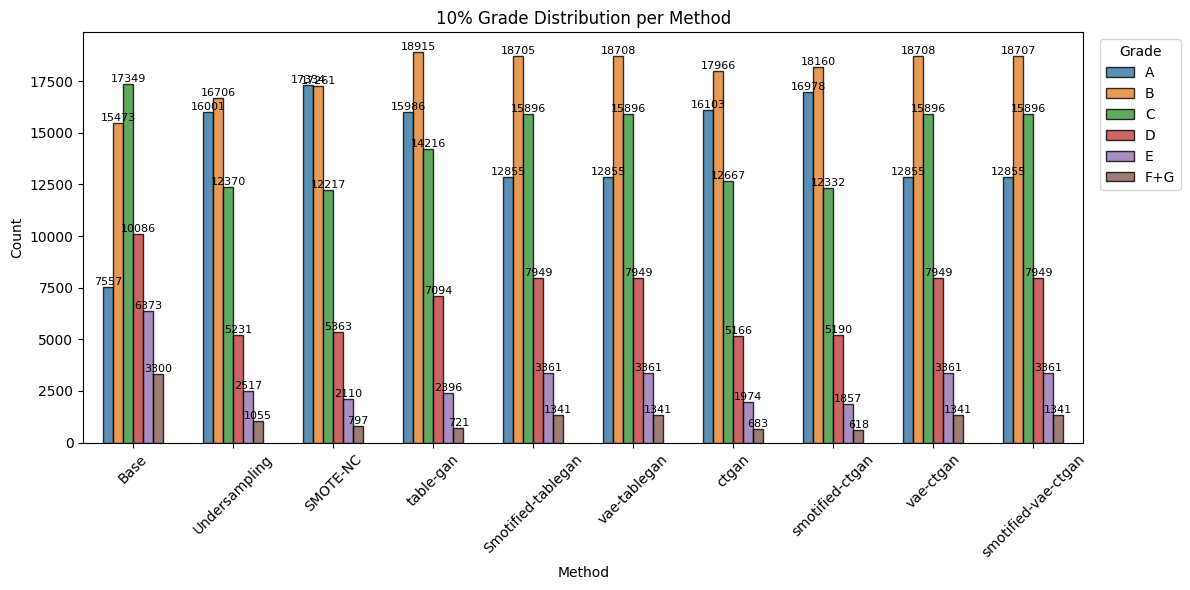

In [51]:
import seaborn as sns

df = portfolio_grade_distribution_df_top.drop(columns='Total')
df_melted = df.melt(id_vars="Method", var_name="Grade", value_name="Count")

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df_melted,
    x="Method",
    y="Count",
    hue="Grade",
    dodge=True,
    width=0.6,
    alpha=0.8,
    edgecolor="black"
)

# 각 막대 위에 값 표시
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:
        ax.text(
            patch.get_x() + patch.get_width() / 2,
            height,
            f'{int(height)}',
            ha='center',
            va='bottom',
            fontsize=8,
            rotation=0
        )

plt.title("10% Grade Distribution per Method")
plt.xticks(rotation=45)
plt.legend(title="Grade", bbox_to_anchor=(1.01, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
"""returns_with_sharpe_df_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"
returns_with_sharpe_df.to_csv(path_or_buf=returns_with_sharpe_df_path+"return_with_sharp.csv", index=False)"""

'returns_with_sharpe_df_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"\nreturns_with_sharpe_df.to_csv(path_or_buf=returns_with_sharpe_df_path+"return_with_sharp.csv", index=False)'

## Benchmark IRR, 무차별 투자

In [ ]:
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_test_irr.csv"
test_df= pd.read_csv(test_data_path)

In [ ]:
import pandas as pd
import numpy as np

results = []

def calculate_benchmark_returns(df: pd.DataFrame, top_percent: float = 0.3, risk_free_rate: float = 0.0):

    # Benchmark 1: IRR 기준 상위 top_percent 투자
    df_sorted_irr = df.sort_values(by="irr", ascending=False)
    top_irr_df = df_sorted_irr.head(int(len(df_sorted_irr) * top_percent))
    
    b1_returns = top_irr_df['return']
    b1_mean = b1_returns.mean() * 100
    b1_std = b1_returns.std()
    b1_sharpe = (b1_mean - risk_free_rate) / b1_std if b1_std != 0 else np.nan

    results.append({
        'portfolio': "benchmark1",
        'Average Return': b1_mean,
        'Std Dev': b1_std,
        'Sharpe Ratio': b1_sharpe
    }) 

    # Benchmark 2: 전체 무차별 투자
    b2_returns = df['return']
    b2_mean = b2_returns.mean() * 100
    b2_std = b2_returns.std() 
    b2_sharpe = (b2_mean - risk_free_rate) / b2_std if b2_std != 0 else np.nan

    results.append({
        'portfolio': "benchmark2",
        'Average Return': b2_mean,
        'Std Dev': b2_std,
        'Sharpe Ratio': b2_sharpe
    }) 

    return results  


In [ ]:
calculate_benchmark_returns(test_df)

benchmark_df = pd.DataFrame(results)

In [ ]:
benchmark_df.head()

,portfolio,Average Return,Std Dev,Sharpe Ratio
0,benchmark1,2.799690,0.383814,7.294384
1,benchmark2,4.351517,0.288939,15.060314


In [ ]:
"""import numpy_financial as npf

def calculate_irr(loan_amnt, installment, term_months):
    cash_flows = [-loan_amnt] + [installment] * term_months
    return npf.irr(cash_flows)


test_data['irr'] = test_data.apply(
    lambda row: calculate_irr(row['loan_amnt'], row['installment'], int(row['term_months'])),
    axis=1
)

test_data_irr_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"
test_data.to_csv(path_or_buf=test_data_irr_path+"return_feature_test_irr.csv", index=False)"""

'import numpy_financial as npf\n\ndef calculate_irr(loan_amnt, installment, term_months):\n    cash_flows = [-loan_amnt] + [installment] * term_months\n    return npf.irr(cash_flows)\n\n\ntest_data[\'irr\'] = test_data.apply(\n    lambda row: calculate_irr(row[\'loan_amnt\'], row[\'installment\'], int(row[\'term_months\'])),\n    axis=1\n)\n\ntest_data_irr_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"\ntest_data.to_csv(path_or_buf=test_data_irr_path+"return_feature_test_irr.csv", index=False)'